In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import os
import time
import copy
from sklearn.metrics import precision_score, recall_score, f1_score
from skimage import exposure

# Data Preprocessing and Augmentation
data_transforms = {
    'train': transforms.Compose([
         transforms.RandomResizedCrop(299),  # Randomly crop to 299x299 for Inception v3
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),  # Randomly change image brightness, contrast, saturation, and hue
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with mean and std of ImageNet dataset
    ]),
    'val': transforms.Compose([
        transforms.Resize(320),  # Resize to 320x320
        transforms.CenterCrop(299),  # Crop the center part to 299x299
        # AdaptiveEqualization(),
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with mean and std of ImageNet dataset
    ]),
}

In [80]:


data_dir = r'D:\GoogleStreetView\Rumble Strip.v6i.folder'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Evaluation Function with Adjustable Threshold
def predict_with_threshold(model, dataloader, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = (probs[:, 1] > threshold).int()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

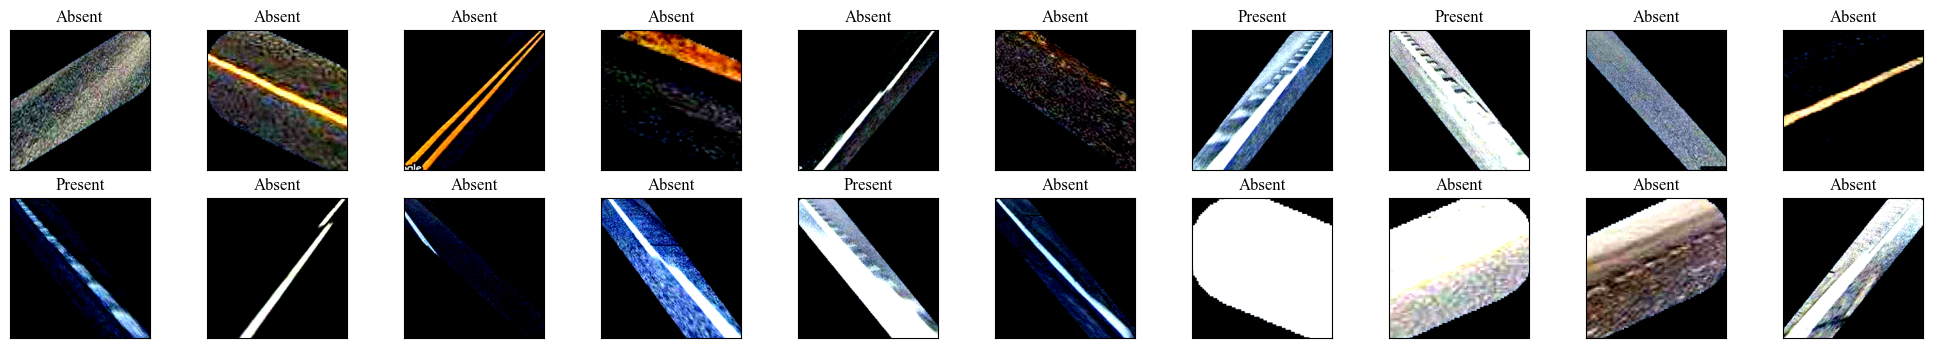

In [62]:
# plot some images in the dataset
import matplotlib.pyplot as plt
import numpy as np
# read some images in the dataset
dataiter = iter(dataloaders['val'])
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
# plot the images in the batch using subplots
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(class_names[labels[idx]])
plt.show()


In [ ]:

save_path = 'D:\GoogleStreetView\TrainingInception_0606'
# read model from checkpoint
ckpt_path = os.path.join(save_path,'best_model.pt')
model_ft = models.inception_v3(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft.AuxLogits.fc = nn.Linear(model_ft.AuxLogits.fc.in_features, len(class_names))  # Handle auxiliary classifier
model_ft = model_ft.to(device)
# evaluate the model using the best model on validation set
model_ft.load_state_dict(torch.load(ckpt_path))
model_ft.eval()

In [57]:

preds, labels = predict_with_threshold(model_ft, dataloaders['val'], threshold=0.65)
f1 = f1_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1 Score: 0.8969
Precision: 0.9009
Recall: 0.8929


In [49]:
# try different thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 1.0, 0.1)
f1_scores = []
precision_scores = []
recall_scores = []
for threshold in thresholds:
    preds, labels = predict_with_threshold(model_ft, dataloaders['val'], threshold=threshold)
    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)


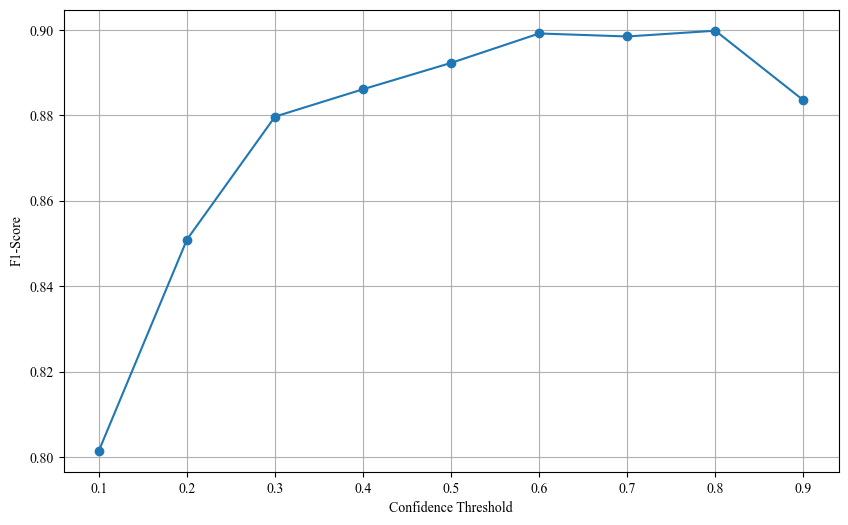

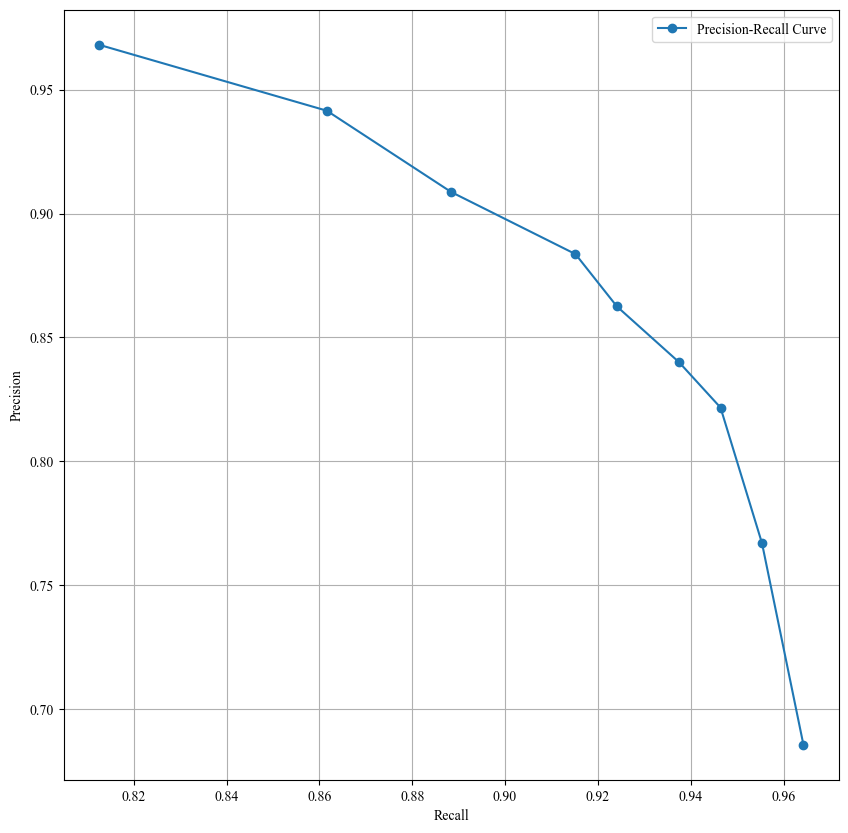

In [52]:
# plot the evaluation metrics
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

# times new roman font
plt.figure(figsize=(10, 6))
plt.grid()
# plot f1 score
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Confidence Threshold')
plt.ylabel('F1-Score')
plt.show()
# plot precision-recall curve
plt.figure(figsize=(10, 10))
plt.grid()
plt.plot(recall_scores, precision_scores, label='Precision-Recall Curve', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [82]:

# load all images and labels from validation set
data_dir = r'D:\GoogleStreetView\Rumble Strip.v6i.folder'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=False, num_workers=4) for x in ['val']}
preds, labels = predict_with_threshold(model_ft, dataloaders['val'], threshold=0.6)
f1 = f1_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)


In [ ]:
# load all images and labels from validation set
data_dir = r'D:\GoogleStreetView\Rumble Strip.v6i.folder'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=False, num_workers=4) for x in ['val']}
# plot some images in the dataset


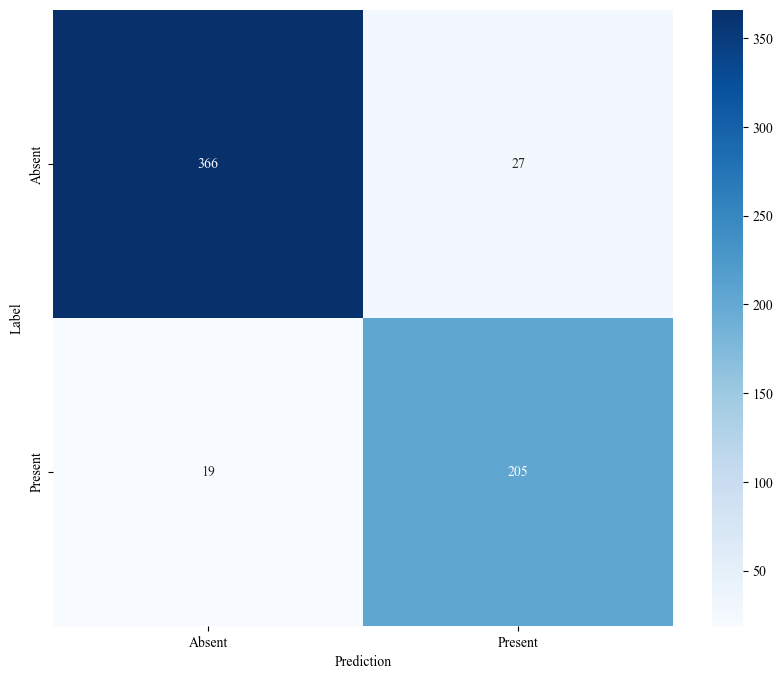

In [66]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

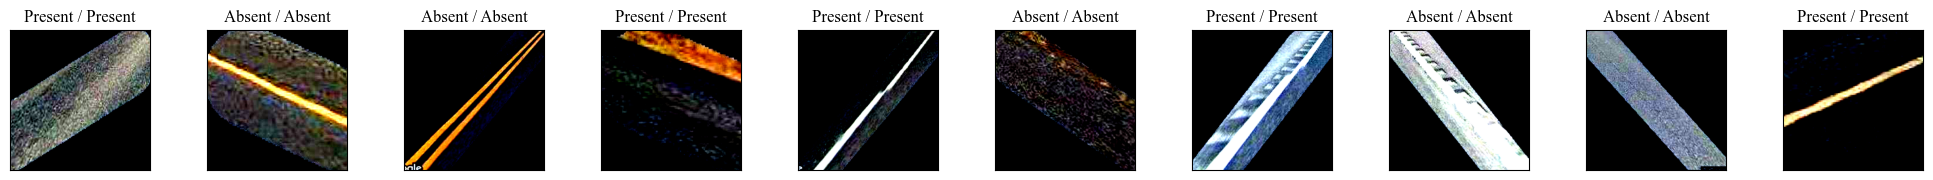

In [78]:
# plot some images with correct predictions
correct_preds = np.where(preds == labels)[0]
fig = plt.figure(figsize=(25, 4))
for idx, correct_pred in enumerate(correct_preds[:10]):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[correct_pred], (1, 2, 0)))
    ax.set_title(f'{class_names[labels[correct_pred]]} / {class_names[preds[correct_pred]]}')
plt.show()

In [75]:
false_pos_preds.shape

(27,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 34 is out of bounds for axis 0 with size 32

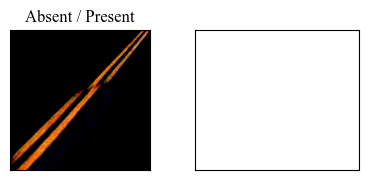

In [73]:
# plot some images with false positive predictions
false_pos_preds = np.where((preds == 1) & (labels == 0))[0]
fig = plt.figure(figsize=(25, 4))
for idx, false_pos_pred in enumerate(false_pos_preds[:10]):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[false_pos_pred], (1, 2, 0)))
    ax.set_title(f'{class_names[labels[false_pos_pred]]} / {class_names[preds[false_pos_pred]]}')
plt.show()